In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load the datasets
train_data = pd.read_csv('dataset/train.csv')
test_data = pd.read_csv('dataset/test.csv')

In [4]:
# 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
emotionLabels = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

emotion_counts = train_data['emotion'].value_counts()

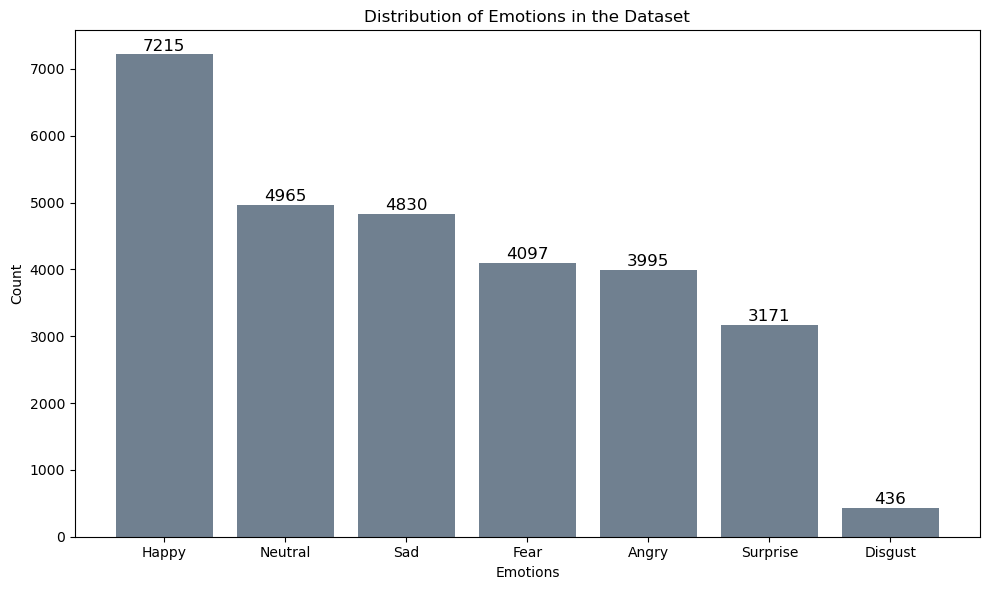

In [5]:
# Count the number of occurrences of each emotion
plt.figure(figsize=(10, 6))

plt.bar([emotionLabels[i] for i in emotion_counts.index], emotion_counts.values, color=['slategray'])

plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Distribution of Emotions in the Dataset')

for i, count in enumerate(emotion_counts.values):
    plt.text(i, count + 10, str(count), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


In [6]:
# Function to convert pixel string to image array
def pixels_to_image(pixels_str):
    pixels = np.array(pixels_str.split(), dtype='float32')  
    return pixels.reshape(48, 48)  # Reshape into 48x48 because the images are 48x48 pixels

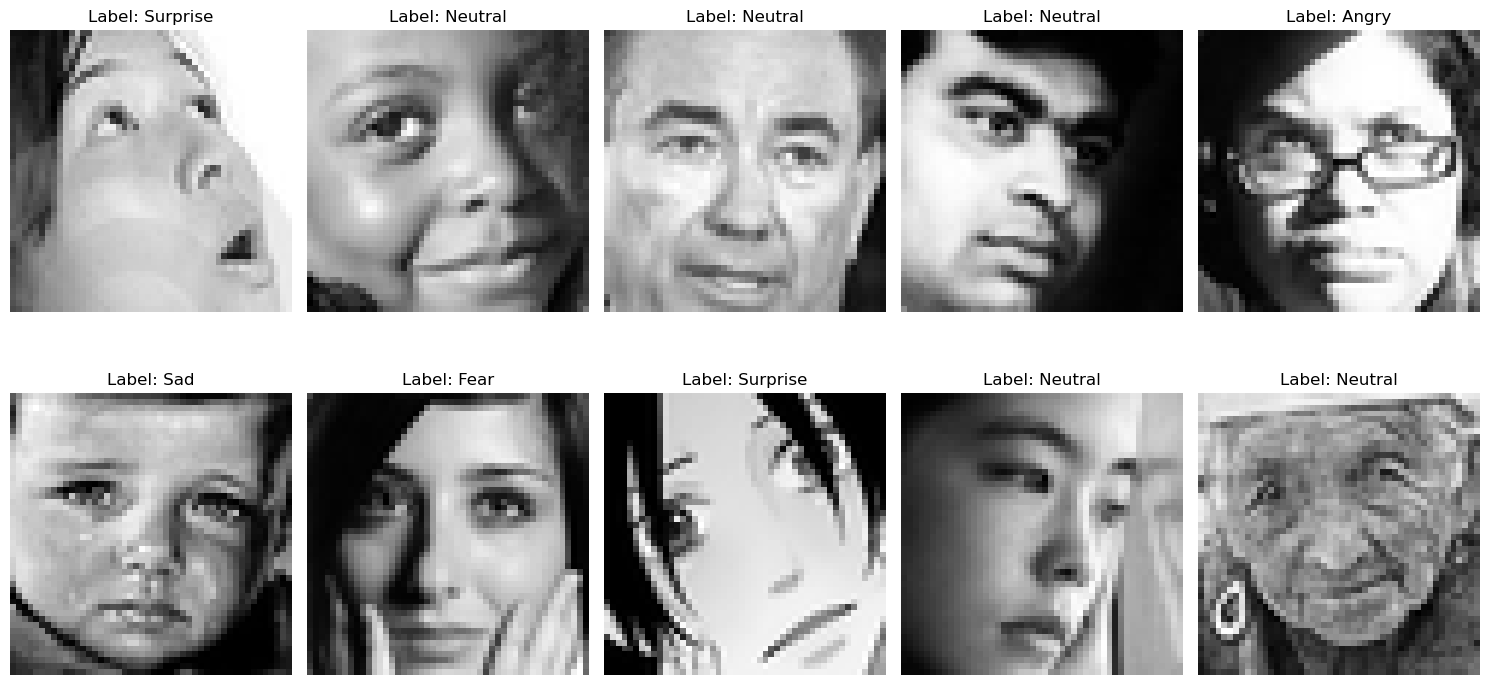

In [8]:
# Display 10 random images
plt.figure(figsize=(15, 8))
for i in range(10):
    idx = np.random.randint(0, len(train_data))

    pixels = train_data.iloc[idx]['pixels']
    label = train_data.iloc[idx]['emotion']  

    # Convert pixels to image
    image = pixels_to_image(pixels)

    # Plot the image
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {emotionLabels[label]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# BUILDING MODEL

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.utils import to_categorical

In [10]:
X = train_data['pixels'].apply(lambda x: np.array(x.split()).astype('float32'))
y = train_data['emotion']

# 48x48 pixels
X = np.stack(X.values)
X = X.reshape(-1, 48, 48, 1) 

# Normalize
X = X / 255.0

# Convert labels to one-hot encoding
y = to_categorical(y, num_classes=7)

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.optimizers import Adam

# Nombre de classes (√©motions)
nb_classes = 7

# Initialisation du mod√®le CNN
model = Sequential()

# 1re couche convolutionnelle
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2e couche convolutionnelle
model.add(Conv2D(128, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3e couche convolutionnelle
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4e couche convolutionnelle
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten + couches fully connected
model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Couche de sortie
model.add(Dense(nb_classes, activation='softmax'))

# Compilation avec Adam
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


c:\Users\bushr\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## ANALYSE OPTIMIZER

Dans cette partie, nous analysons le r√¥le de l‚Äôoptimiseur Adam dans l‚Äôapprentissage de notre CNN. L‚Äô√©tude porte notamment sur :

La fonction de perte utilis√©e

La nature math√©matique du probl√®me d‚Äôoptimisation

Les hyperparam√®tres cl√©s de l‚Äôalgorithme Adam

Les avantages et limites d‚ÄôAdam dans un contexte non convexe

Une comparaison th√©orique avec SGD + momentum

### ETAPE 1 _ Etudier la fonction de perte

Cette fonction est standard pour la classification multi-classes. Elle mesure la diff√©rence entre la distribution pr√©dite (apr√®s softmax) et la distribution vraie (one-hot).

In [13]:
from tensorflow.keras.losses import CategoricalCrossentropy

loss_fn = CategoricalCrossentropy()
print("Fonction de perte utilis√©e :", loss_fn)

Fonction de perte utilis√©e : <keras.src.losses.losses.CategoricalCrossentropy object at 0x00000139F485D2B0>


* CONVEXITE:

1- La fonction de perte n'est pas convexe car 
La categorical_crossentropy est convexe seule, mais...

Le mod√®le est un r√©seau de neurones profond, ce qui introduit :

* ReLU (non-lin√©aire)

* Convolution + MaxPooling (non-lin√©aires ou non diff√©remment lin√©aires)

* Dense avec activation

Donc l‚Äôoptimisation devient un probl√®me non convexe, √† cause de la composition de fonctions non lin√©aires.

Par contre, elle est bien diff√©rentiable car Oui, partout sauf aux points anguleux des ReLU, mais ces points sont n√©gligeables en pratique.

Ce qu'il faut retenir:
La fonction de perte categorical_crossentropy est utilis√©e pour la classification multi-classes. Math√©matiquement, elle correspond √† l'entropie crois√©e entre deux distributions de probabilit√©.
Elle est convexe si elle est appliqu√©e √† une sortie softmax dans un mod√®le lin√©aire, mais le mod√®le CNN n'√©tant pas lin√©aire, la fonction de perte totale devient non convexe. Cela rend l'optimisation plus difficile (possibles minima locaux, plateaux, oscillations...).

In [14]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=30,
                    batch_size=128)


Epoch 1/30
180/180 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 410s 2s/step - accuracy: 0.2386 - loss: 2.0037 - val_accuracy: 0.2584 - val_loss: 2.0257
Epoch 2/30
 78/180 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3:45 2s/step - accuracy: 0.3513 - loss: 1.6525

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Fonction de perte (Adam)")
    plt.xlabel("√âpoques")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Pr√©cision (Accuracy)")
    plt.xlabel("√âpoques")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

## ETAPE 2 _ Analyser Adam comme algorithme d'optimisation

### Optimiseur Adam ‚Äî Introduction

L‚Äôalgorithme **Adam** (Adaptive Moment Estimation) est l‚Äôun des plus utilis√©s pour entra√Æner des r√©seaux de neurones profonds, notamment les CNN.

Il combine deux id√©es :
- Le **momentum** (acc√©l√®re la descente en accumulant l‚Äôhistorique des gradients)
- L‚Äô**adaptation du learning rate** pour chaque poids (comme RMSProp)

C‚Äôest une m√©thode efficace pour les fonctions de perte **non convexes**, ce qui est notre cas ici (CNN + cross-entropy + ReLU).


### Les hyperparam√®tres cl√©s de Adam √† analyser

| Param√®tre | Valeur par d√©faut | R√¥le |
|-----------|-------------------|------|
| `learning_rate` | `0.001` | Pas d‚Äôapprentissage global |
| `beta_1` | `0.9` | Moyenne des gradients (momentum) |
| `beta_2` | `0.999` | Moyenne des carr√©s des gradients |
| `epsilon` | `1e-7` | Stabilit√© num√©rique |
| `amsgrad` | `False` | Variante am√©lior√©e pour convergence th√©orique |
| `weight_decay` | `None` | R√©gularisation L2 des poids (√©vite overfitting) |

Nous allons tester diff√©rentes combinaisons pour mesurer l‚Äôimpact sur la **fonction de perte** et la **vitesse de convergence**.


In [ ]:
from tensorflow.keras.models import clone_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

def train_with_adam(lr=0.001, beta1=0.9, beta2=0.999, eps=1e-7, decay=None, amsgrad=False, epochs=15):
    # Cloner le mod√®le de base
    model_adam = clone_model(model)
    model_adam.set_weights(model.get_weights())

    # Optimiseur Adam avec hyperparam√®tres personnalis√©s
    opt = Adam(learning_rate=lr, beta_1=beta1, beta_2=beta2, epsilon=eps,
               weight_decay=decay, amsgrad=amsgrad)

    model_adam.compile(optimizer=opt,
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

    history = model_adam.fit(X_train, y_train,
                             validation_data=(X_test, y_test),
                             batch_size=128,
                             epochs=epochs,
                             verbose=0)
    return history


In [ ]:
# Valeurs de learning rate √† tester
learning_rates = [1e-4, 1e-3, 1e-2]

# Valeurs de beta_1 √† tester (momentum du gradient)
beta1_values = [0.8, 0.9, 0.99]

# Valeurs de beta_2 √† tester (stabilit√© du carr√© du gradient)
beta2_values = [0.9, 0.99, 0.999]

# Valeurs de weight decay (r√©gularisation L2)
weight_decays = [None, 1e-5, 1e-4]


In [ ]:
# Stockage des r√©sultats
results_adam = {}

# Test Learning Rate
for lr in learning_rates:
    label = f"LR={lr}"
    results_adam[label] = train_with_adam(lr=lr)

# Test Beta_1
for b1 in beta1_values:
    label = f"Beta1={b1}"
    results_adam[label] = train_with_adam(beta1=b1)

# Test Beta_2
for b2 in beta2_values:
    label = f"Beta2={b2}"
    results_adam[label] = train_with_adam(beta2=b2)

# Test Weight Decay
for wd in weight_decays:
    label = f"WeightDecay={wd if wd else 'None'}"
    results_adam[label] = train_with_adam(decay=wd)


In [ ]:
plt.figure(figsize=(16, 10))
for name, hist in results_adam.items():
    plt.plot(hist.history['val_loss'], label=name)

plt.title("Comparaison des effets des hyperparam√®tres d'Adam sur la validation loss")
plt.xlabel("√âpoques")
plt.ylabel("Validation Loss")
plt.legend(loc="upper right", fontsize=10)
plt.grid(True)
plt.show()


### R√©sum√© des impacts observ√©s :

- üìâ `learning_rate` trop faible : convergence tr√®s lente, parfois pas de r√©elle descente.
- üìà `learning_rate` trop grand : descente rapide mais parfois instable (rebonds).
- üîÅ `beta_1` √©lev√© ‚Üí tr√®s stable mais lent ; faible ‚Üí plus r√©actif, mais plus bruit√©.
- üîÇ `beta_2` √©lev√© ‚Üí utile quand les gradients sont tr√®s variables (ex : d√©but d'entra√Ænement).
- üß± `weight_decay` : stabilise la loss apr√®s plusieurs √©poques, r√©duit overfitting.

### Conseil :

- Commencer avec les valeurs par d√©faut : `lr=0.001`, `beta_1=0.9`, `beta_2=0.999`
- Si overfitting ‚Üí ajouter `weight_decay`
- Si convergence lente ‚Üí tester `lr=0.01` et `beta_1=0.8`


In [ ]:
# Visualiser l'accuracy en validation 
plt.figure(figsize=(16, 10))
for name, hist in results_adam.items():
    plt.plot(hist.history['val_accuracy'], label=name)

plt.title("üìà Validation Accuracy selon les hyperparam√®tres Adam")
plt.xlabel("√âpoques")
plt.ylabel("Validation Accuracy")
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.show()


### üß† Analyse de l'accuracy :

- Les courbes permettent de rep√©rer :
    - üìà Une mont√©e rapide = bonne **vitesse de convergence**
    - üîÅ Une stabilisation haute = bon **plateau de performance**
    - üìâ Une chute soudaine apr√®s mont√©e = signe de **sur-apprentissage**

Compare les pics de validation accuracy et observe :
- Quel `learning_rate` donne la meilleure mont√©e ?
- Quel `beta1` stabilise le mieux ?
- L‚Äôimpact du `weight_decay` sur la stabilit√© en fin d‚Äôapprentissage.


In [ ]:
# Analyser la vitesse de convergence 
#On affiche ici l‚Äô√©poque √† laquelle la validation accuracy d√©passe un seuil (ex: 55%).
def get_convergence_epoch(history, threshold=0.55):
    acc = history.history['val_accuracy']
    for i, a in enumerate(acc):
        if a >= threshold:
            return i + 1
    return None

for name, hist in results_adam.items():
    epoch = get_convergence_epoch(hist)
    if epoch:
        print(f"{name} atteint {threshold*100:.0f}% val_acc √† l‚Äô√©poque {epoch}")
    else:
        print(f"{name} n‚Äôatteint pas {threshold*100:.0f}% val_acc")


## Compiler le mod√®le avec les meilleurs hyperparam√®tres choisis

In [ ]:
model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv2d (Conv2D)                 ‚îÇ (None, 46, 46, 64)     ‚îÇ           640 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d (MaxPooling2D)    ‚îÇ (None, 23, 23, 64)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 23, 23, 64)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_1 (Conv2D)               ‚îÇ (None, 21, 21, 128)    ‚îÇ        73,856 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_1 (MaxPooling2D)  ‚îÇ (None, 10, 10, 128)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (None, 10, 10, 128)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_2 (Conv2D)               ‚îÇ (None, 8, 8, 128)      ‚îÇ       147,584 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_2 (MaxPooling2D)  ‚îÇ (None, 4, 4, 128)      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_2 (Dropout)             ‚îÇ (None, 4, 4, 128)      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten (Flatten)               ‚îÇ (None, 2048)           ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 64)             ‚îÇ       131,136 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ

 Total params: 353,671 (1.35 MB)

 Trainable params: 353,671 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [17]:
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,
                    batch_size=256,
                    callbacks=[early_stopping])

model.save('model_best.keras')

# EvaluatE
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")


Epoch 1/100
90/90 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 19s 202ms/step - accuracy: 0.2251 - loss: 1.8555 - val_accuracy: 0.2618 - val_loss: 1.8099
Epoch 2/100
90/90 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 18s 202ms/step - accuracy: 0.2494 - loss: 1.7937 - val_accuracy: 0.3220 - val_loss: 1.7039
Epoch 3/100
90/90 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 18s 202ms/step - accuracy: 0.3171 - loss: 1.7061 - val_accuracy: 0.3917 - val_loss: 1.5851
Epoch 4/100
90/90 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 18s 204ms/step - accuracy: 0.3713 - loss: 1.6081 - val_accuracy: 0.4115 - val_loss: 1.5114
Epoch 5/100
90/90 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 18s 204ms/step - accuracy: 0.4077 - loss: 1.5362 - val_accuracy: 0.4596 - val_loss: 1.4335
Epoch 6/100
90/90 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 19s 211ms/step - accuracy: 0.4293 - loss: 1.4874 - val_accuracy: 0.4786

In [18]:
def plot_model_history_only(history):
  """
  Plots the training and validation metrics from the model's history object.

  Args:
    history: A tf.keras.callbacks.History object returned by model.fit().
  """
  metrics = [key for key in history.history if not key.startswith('val_')]

  for metric_name in metrics:
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(history.history[metric_name]) + 1)
    plt.plot(epochs, history.history[metric_name], 'b-', label=f'Training {metric_name}')

    val_metric_name = f'val_{metric_name}'
    if val_metric_name in history.history:
      plt.plot(epochs, history.history[val_metric_name], 'r-', label=f'Validation {metric_name}')
      plt.legend()

    plt.title(f'Training and Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name.capitalize())
    plt.grid(True)
    plt.show()


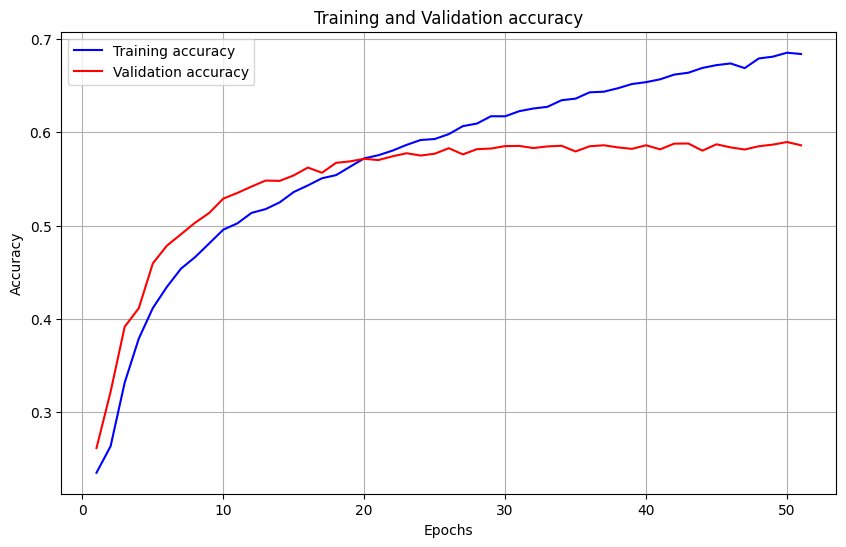

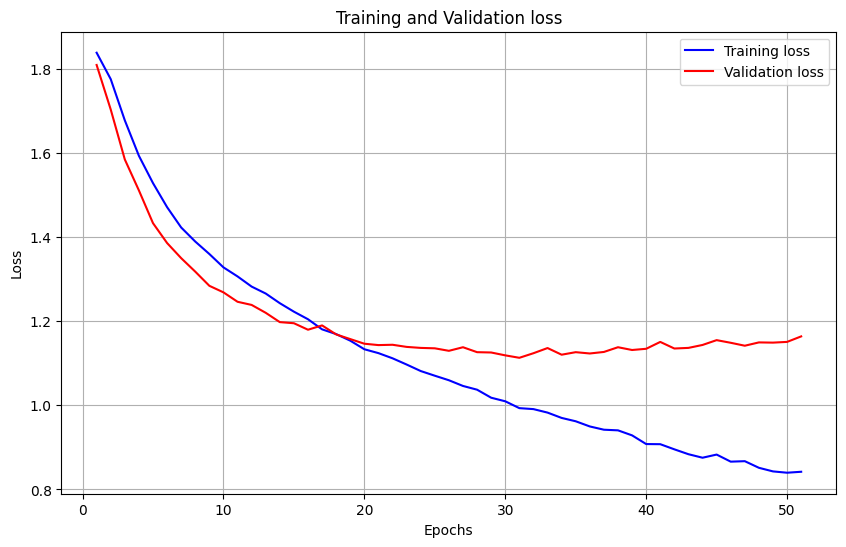

In [19]:
plot_model_history_only(history)